# Notebook 06 (Kaggle): RAG + LLM Integration for Explainable Fraud Detection

This notebook is a Kaggle-ready copy of the local RAG + LLM workflow. It mirrors the original pipeline while:
- Installing required libraries inside the Kaggle runtime
- Using Kaggle data paths and writable working directories
- Defaulting to a local Hugging Face instruct model when no API key is configured
- Preserving template fallbacks so the notebook remains usable even without GPU access

In [ ]:
# Cell 1: Install dependencies required on Kaggle
print("📦 Installing required packages (this may take a couple of minutes)...")
!pip install -q langchain langchain-community langchain-core langchain-text-splitters sentence-transformers faiss-cpu langchain-openai transformers>=4.40 accelerate bitsandbytes safetensors tiktoken
print("✅ Installation complete")

In [2]:
# Cell 2: Environment diagnostics and basic imports
import os
import sys
import numpy as np
import pandas as pd
import torch

RUNNING_ON_KAGGLE = bool(os.environ.get('KAGGLE_KERNEL_RUN_TYPE'))
print(f"🐍 Python version: {sys.version}")
print(f"📁 Running on Kaggle: {RUNNING_ON_KAGGLE}")
print(f"✅ NumPy: {np.__version__}")
print(f"✅ Pandas: {pd.__version__}")
print(f"✅ PyTorch: {torch.__version__}")
print(f"✅ CUDA available: {torch.cuda.is_available()}")

🐍 Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
📁 Running on Kaggle: True
✅ NumPy: 1.26.4
✅ Pandas: 2.2.3
✅ PyTorch: 2.6.0+cu124
✅ CUDA available: True


In [3]:
# Cell 3: Initial LangChain import checks (mirrors the source notebook)
try:
    from langchain_community.embeddings import HuggingFaceEmbeddings
    from langchain_community.vectorstores import FAISS, Chroma
    from langchain_text_splitters import RecursiveCharacterTextSplitter
    from langchain_core.documents import Document
    from langchain_core.prompts import PromptTemplate
    RAG_AVAILABLE = True
    print('✅ LangChain community components available')
except ImportError as exc:
    RAG_AVAILABLE = False
    print('⚠️ LangChain community packages missing. Install with:')
    print('   pip install "langchain>=0.2.0" langchain-community langchain-core langchain-text-splitters')
    print(f'   Details: {exc}')
import torch
import torch.nn as nn
import torch.nn.functional as F

# Confirm optional components as in the source notebook
try:
    from langchain_community.embeddings import HuggingFaceEmbeddings
    from langchain_community.vectorstores import FAISS, Chroma
    from langchain_text_splitters import RecursiveCharacterTextSplitter
    from langchain_core.documents import Document
    from langchain_core.prompts import PromptTemplate
    try:
        from langchain_community.llms import HuggingFacePipeline
        LLM_AVAILABLE = True
    except ImportError:
        LLM_AVAILABLE = False
    RAG_AVAILABLE = True
    print('✅ Core RAG imports successful')
    print('📦 Working components: Embeddings, Vector Stores, Text Splitting')
except ImportError as e:
    RAG_AVAILABLE = False
    print(f'❌ RAG import error: {e}')

try:
    from sentence_transformers import SentenceTransformer
    SBERT_AVAILABLE = True
    print('✅ Sentence Transformers available')
except ImportError:
    SBERT_AVAILABLE = False
    print('⚠️ Sentence Transformers not available')

print(f'\nPyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')

✅ LangChain community components available
✅ Core RAG imports successful
📦 Working components: Embeddings, Vector Stores, Text Splitting


2025-11-01 00:20:20.034537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761956420.057529     115 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761956420.064479     115 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Sentence Transformers available

PyTorch version: 2.6.0+cu124
CUDA available: True


In [5]:
# Cell 4: Core imports, Kaggle-aware configuration, and library detection
import json
import pickle
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional
import time
from tqdm.auto import tqdm

try:
    from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
    TRANSFORMERS_AVAILABLE = True
except ImportError:
    TRANSFORMERS_AVAILABLE = False

RAG_AVAILABLE = False
LLM_AVAILABLE = False
LEGACY_LANGCHAIN = False
community_exc = None
legacy_exc = None

try:
    from langchain_community.embeddings import HuggingFaceEmbeddings
    from langchain_community.vectorstores import FAISS, Chroma
    from langchain_text_splitters import RecursiveCharacterTextSplitter
    from langchain_core.documents import Document
    from langchain_core.prompts import PromptTemplate
    RAG_AVAILABLE = True
    print('✅ LangChain community imports successful')
except ImportError as exc:
    community_exc = exc
    try:
        from langchain.embeddings import HuggingFaceEmbeddings
        from langchain.vectorstores import FAISS, Chroma
        from langchain.text_splitter import RecursiveCharacterTextSplitter
        from langchain.docstore.document import Document
        from langchain.prompts import PromptTemplate
        RAG_AVAILABLE = True
        LEGACY_LANGCHAIN = True
        print('✅ LangChain legacy imports successful')
    except ImportError as exc2:
        legacy_exc = exc2
        print('⚠️ LangChain components not available. Install with:')
        print('   pip install "langchain>=0.2.0" langchain-community langchain-core langchain-text-splitters')
        print(f'   Community error: {community_exc}')
        print(f'   Legacy error: {legacy_exc}')

if RAG_AVAILABLE:
    try:
        if LEGACY_LANGCHAIN:
            from langchain.llms import HuggingFacePipeline
        else:
            from langchain_community.llms import HuggingFacePipeline
        LLM_AVAILABLE = True
    except ImportError:
        LLM_AVAILABLE = False

try:
    from sentence_transformers import SentenceTransformer
    SBERT_AVAILABLE = True
    print('✅ Sentence Transformers available')
except ImportError:
    SBERT_AVAILABLE = False
    print('⚠️ Sentence Transformers not available')

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print(f'\nPyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
if TRANSFORMERS_AVAILABLE:
    print('✅ Transformers library detected (local LLM ready)')
else:
    print('ℹ️ Install transformers, accelerate, bitsandbytes for local LLM support:')
    print('   pip install "transformers>=4.40" accelerate bitsandbytes safetensors')

✅ LangChain community imports successful
✅ Sentence Transformers available

PyTorch version: 2.6.0+cu124
CUDA available: True
✅ Transformers library detected (local LLM ready)


## Path Configuration (Kaggle-aware)

In [21]:
from pathlib import Path

if RUNNING_ON_KAGGLE:
    BASE_PATH = Path('/kaggle/input/flag-finance').resolve()
    WORKING_ROOT = Path('/kaggle/working').resolve()
    PROCESSED_PATH = BASE_PATH / 'processed' / 'processed'
    RAW_PATH = BASE_PATH / 'raw'
    INPUT_RESULTS_PATH = BASE_PATH / 'results' / 'results'
else:
    BASE_PATH = Path('..').resolve()
    WORKING_ROOT = BASE_PATH
    DATA_PATH = BASE_PATH / 'data'
    PROCESSED_PATH = DATA_PATH / 'processed'
    RAW_PATH = DATA_PATH / 'raw'
    INPUT_RESULTS_PATH = DATA_PATH / 'results'

MODELS_PATH = WORKING_ROOT / 'models'
RESULTS_PATH = WORKING_ROOT / 'results'
OUTPUT_PATH = WORKING_ROOT / 'rag_output'
VECTOR_DB_PATH = WORKING_ROOT / 'vector_db'

for directory in [MODELS_PATH, RESULTS_PATH, OUTPUT_PATH, VECTOR_DB_PATH]:
    directory.mkdir(exist_ok=True, parents=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('📁 Path Configuration:')
print(f'   Input base: {BASE_PATH}')
print(f'   Processed data: {PROCESSED_PATH}')
print(f'   Raw data: {RAW_PATH}')
print(f'   Working root: {WORKING_ROOT}')
print(f'   Models (writable): {MODELS_PATH}')
print(f'   Results (writable): {RESULTS_PATH}')
print(f'   Output: {OUTPUT_PATH}')
print(f'   Vector DB: {VECTOR_DB_PATH}')
print(f'\n🔧 Device: {device}')

📁 Path Configuration:
   Input base: /kaggle/input/flag-finance
   Processed data: /kaggle/input/flag-finance/processed/processed
   Raw data: /kaggle/input/flag-finance/raw
   Working root: /kaggle/working
   Models (writable): /kaggle/working/models
   Results (writable): /kaggle/working/results
   Output: /kaggle/working/rag_output
   Vector DB: /kaggle/working/vector_db

🔧 Device: cuda


## Load Transaction Data and Model Predictions

In [23]:
print('='*70)
print('LOADING DATA AND PREDICTIONS')
print('='*70)


# Load transaction data
paysim_file = PROCESSED_PATH / 'paysim_sample_enhanced.csv'
if not paysim_file.exists():
    paysim_file = PROCESSED_PATH / 'paysim_data_enhanced.csv'

if paysim_file.exists():
    df = pd.read_csv(paysim_file)
    print(f'\n✅ Loaded transaction data: {df.shape}')
    print(f'   Columns: {list(df.columns)}')
else:
    raise FileNotFoundError(f'Transaction data not found at {paysim_file}')

# Load fusion model results, prefer writable directory but fall back to input snapshot
fusion_results_file = RESULTS_PATH / 'fusion_results.json'
if not fusion_results_file.exists():
    candidate = INPUT_RESULTS_PATH / 'fusion_results.json'
    if candidate.exists():
        fusion_results_file = candidate

if fusion_results_file.exists():
    with open(fusion_results_file, 'r') as f:
        fusion_results = json.load(f)
    print(f'\n✅ Loaded fusion results')
    print(f'   Best model: {fusion_results["best_fusion_model"]["name"]}')
else:
    print(f'\n⚠️ Fusion results not found - will use sample predictions')
    fusion_results = None

LOADING DATA AND PREDICTIONS

✅ Loaded transaction data: (127252, 22)
   Columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'balanceOrig_diff', 'balanceDest_diff', 'balance_error_orig', 'balance_error_dest', 'hour', 'day', 'is_night', 'amount_log', 'amount_sqrt', 'amount_zscore', 'amount_outlier']

✅ Loaded fusion results
   Best model: CrossModalFusion


## Create Fraud Case Database

In [24]:
def create_fraud_case_descriptions(df: pd.DataFrame, max_cases: int = 1000) -> List[Dict]:
    """Create detailed textual descriptions of fraud cases for the vector database."""
    print(f'\n📝 Creating fraud case descriptions...')

    fraud_cases = df[df['isFraud'] == 1].copy()
    if len(fraud_cases) > max_cases:
        fraud_cases = fraud_cases.sample(n=max_cases, random_state=42)

    print(f'   Processing {len(fraud_cases)} fraud cases...')
    case_documents = []

    for idx, row in tqdm(fraud_cases.iterrows(), total=len(fraud_cases), desc='Creating cases'):
        description = f"""
FRAUD CASE #{idx}

Transaction Details:
- Type: {row.get('type', 'UNKNOWN')}
- Amount: ${row.get('amount', 0):,.2f}
- Time: Step {row.get('step', 0)} (Hour {row.get('hour', 'N/A')})
- Weekend: {'Yes' if row.get('is_weekend', 0) == 1 else 'No'}

Account Balances:
- Origin Old Balance: ${row.get('oldbalanceOrg', 0):,.2f}
- Origin New Balance: ${row.get('newbalanceOrig', 0):,.2f}
- Destination Old Balance: ${row.get('oldbalanceDest', 0):,.2f}
- Destination New Balance: ${row.get('newbalanceDest', 0):,.2f}

Fraud Indicators:
- Balance Error (Origin): ${abs(row.get('balance_error_orig', 0)):,.2f}
- Balance Error (Dest): ${abs(row.get('balance_error_dest', 0)):,.2f}
- Flagged by System: {'Yes' if row.get('isFlaggedFraud', 0) == 1 else 'No'}

Pattern Analysis:
- High amount transfer with balance inconsistencies
- Suspicious account behavior detected
- Transaction type: {row.get('type', 'UNKNOWN')}
"""

        case_documents.append({
            'case_id': str(idx),
            'description': description.strip(),
            'transaction_type': row.get('type', 'UNKNOWN'),
            'amount': float(row.get('amount', 0)),
            'metadata': {
                'step': int(row.get('step', 0)),
                'type': str(row.get('type', 'UNKNOWN')),
                'amount': float(row.get('amount', 0))
            }
        })

    print(f'\n✅ Created {len(case_documents)} fraud case descriptions')
    return case_documents

fraud_cases = create_fraud_case_descriptions(df, max_cases=500)
cases_file = OUTPUT_PATH / 'fraud_cases_database.json'
with open(cases_file, 'w') as f:
    json.dump(fraud_cases, f, indent=2)

print(f'\n💾 Saved fraud cases to: {cases_file}')


📝 Creating fraud case descriptions...
   Processing 173 fraud cases...


Creating cases:   0%|          | 0/173 [00:00<?, ?it/s]


✅ Created 173 fraud case descriptions

💾 Saved fraud cases to: /kaggle/working/rag_output/fraud_cases_database.json


## Build Vector Database for RAG

In [25]:
if not RAG_AVAILABLE or not SBERT_AVAILABLE:
    print('⚠️ RAG libraries not available. Skipping vector database creation.')
    print('Install with: pip install langchain sentence-transformers faiss-cpu')
else:
    print('='*70)
    print('BUILDING VECTOR DATABASE')
    print('='*70)

    print('\n📦 Loading embedding model...')
    embedding_model = HuggingFaceEmbeddings(
        model_name='sentence-transformers/all-MiniLM-L6-v2',
        model_kwargs={'device': 'cuda' if torch.cuda.is_available() else 'cpu'}
    )
    print('✅ Embedding model loaded')

    documents = [
        Document(
            page_content=case['description'],
            metadata=case['metadata']
        )
        for case in fraud_cases
    ]

    print(f'\n🔨 Building FAISS vector database with {len(documents)} documents...')
    vector_store = FAISS.from_documents(
        documents=documents,
        embedding=embedding_model
    )
    vector_store.save_local(str(VECTOR_DB_PATH / 'fraud_cases_faiss'))

    print(f'✅ Vector database created and saved to: {VECTOR_DB_PATH}')
    print(f'   Total vectors: {len(documents)}')

BUILDING VECTOR DATABASE

📦 Loading embedding model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Embedding model loaded

🔨 Building FAISS vector database with 173 documents...
✅ Vector database created and saved to: /kaggle/working/vector_db
   Total vectors: 173


## Retrieval System

In [26]:
class FraudCaseRetriever:
    """Retrieve similar fraud cases for explanation."""

    def __init__(self, vector_store_path: Path, embedding_model):
        self.vector_store = FAISS.load_local(
            str(vector_store_path),
            embeddings=embedding_model,
            allow_dangerous_deserialization=True
        )
        self.retriever = self.vector_store.as_retriever(
            search_kwargs={'k': 3}
        )

    def retrieve_similar_cases(self, query: str, k: int = 3) -> List[Document]:
        return self.vector_store.similarity_search(query, k=k)

    def create_query_from_transaction(self, transaction: Dict) -> str:
        query = f"""
Transaction type: {transaction.get('type', 'UNKNOWN')}
Amount: ${transaction.get('amount', 0):,.2f}
Balance inconsistencies detected
Suspicious account behavior
"""
        return query.strip()

if RAG_AVAILABLE and SBERT_AVAILABLE:
    retriever = FraudCaseRetriever(
        vector_store_path=VECTOR_DB_PATH / 'fraud_cases_faiss',
        embedding_model=embedding_model
    )
    print('✅ Fraud case retriever initialized')
else:
    retriever = None
    print('⚠️ Retriever not available (missing dependencies)')

✅ Fraud case retriever initialized


## LLM Prompt Templates

In [27]:
FRAUD_EXPLANATION_TEMPLATE = """
You are an expert fraud analyst explaining why a transaction was flagged as fraudulent.

CURRENT TRANSACTION:
{transaction_details}

MODEL PREDICTION:
- Fraud Probability: {fraud_probability:.2%}
- Prediction: {prediction}
- Confidence: {confidence}

SIMILAR HISTORICAL FRAUD CASES:
{similar_cases}

TASK:
Provide a clear, professional explanation of why this transaction was flagged as fraud.
Include:
1. Key suspicious indicators
2. Comparison with similar fraud cases
3. Risk factors and patterns
4. Recommended action

Keep the explanation concise (3-4 sentences) and actionable.

EXPLANATION:
"""

LEGIT_EXPLANATION_TEMPLATE = """
You are an expert fraud analyst explaining why a transaction was classified as legitimate.

CURRENT TRANSACTION:
{transaction_details}

MODEL PREDICTION:
- Fraud Probability: {fraud_probability:.2%}
- Prediction: {prediction}
- Confidence: {confidence}

TASK:
Provide a brief explanation of why this transaction appears legitimate.
Include:
1. Normal transaction indicators
2. Why it doesn't match fraud patterns
3. Confidence assessment

Keep the explanation concise (2-3 sentences).

EXPLANATION:
"""

print('✅ Prompt templates defined')

✅ Prompt templates defined


## Explanation Generator

In [31]:
class FraudExplainer:
    """Generate natural language explanations for fraud predictions."""

    def __init__(self,
                 retriever=None,
                 use_llm: bool = False,
                 api_key: Optional[str] = None,
                 local_model: Optional[str] = None,
                 model_kwargs: Optional[Dict] = None,
                 generation_kwargs: Optional[Dict] = None):
        self.retriever = retriever
        self.llm = None
        self.llm_error = None
        self.requested_llm = use_llm
        self.api_key = api_key or os.getenv('OPENAI_API_KEY')
        self.local_model = local_model
        self.model_kwargs = model_kwargs or {}
        self.generation_kwargs = generation_kwargs or {'max_new_tokens': 220, 'temperature': 0.3}
        self.llm_backend = None

        if use_llm and not (self.api_key or self.local_model):
            print('⚠️ use_llm=True requested but no API key or local model provided.')

        self.use_llm = bool(use_llm and (self.api_key or self.local_model))

        if self.use_llm:
            if self.api_key:
                try:
                    from langchain_openai import OpenAI
                    self.llm = OpenAI(temperature=0.3, api_key=self.api_key)
                    self.llm_backend = 'openai'
                    print('✅ OpenAI LLM initialized')
                except Exception as exc:
                    self.llm_error = str(exc)
                    print(f'⚠️ LLM initialization failed: {exc}')
                    self.use_llm = False
            elif self.local_model:
                self._init_local_llm()

    def _init_local_llm(self):
        if not TRANSFORMERS_AVAILABLE:
            print('⚠️ transformers not installed – run "pip install transformers accelerate bitsandbytes" to use a local LLM.')
            self.use_llm = False
            return
        if self.local_model is None:
            print('⚠️ No local model name provided.')
            self.use_llm = False
            return
        model_name = self.local_model
        print(f'🚀 Loading local instruct model: {model_name}')
        try:
            tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
            load_kwargs = {'trust_remote_code': True, **self.model_kwargs}
            load_kwargs.setdefault('device_map', 'auto')
            model = AutoModelForCausalLM.from_pretrained(model_name, **load_kwargs)
            generation_pipeline = pipeline(
                task='text-generation',
                model=model,
                tokenizer=tokenizer,
                pad_token_id=tokenizer.eos_token_id
            )
            self.llm = generation_pipeline
            self.llm_backend = 'huggingface-pipeline'
            print('✅ Local LLM initialized (Hugging Face pipeline)')
        except Exception as exc:
            self.llm_error = str(exc)
            print(f'⚠️ Local LLM initialization failed: {exc}')
            self.use_llm = False

    def _gather_similar_cases(self, transaction: Dict, k: int = 3) -> List[Document]:
        if not self.retriever:
            return []
        query = self.retriever.create_query_from_transaction(transaction)
        try:
            return self.retriever.retrieve_similar_cases(query, k=k)
        except Exception as exc:
            print(f'⚠️ Similar case retrieval failed: {exc}')
            return []

    def _summarize_similar_cases(self, docs: List[Document]) -> str:
        if not docs:
            return 'No similar cases retrieved.'
        summaries = []
        for doc in docs:
            metadata = doc.metadata or {}
            case_type = metadata.get('type', 'UNKNOWN')
            case_amount = metadata.get('amount', 0)
            case_step = metadata.get('step', 'N/A')
            summaries.append(f"{case_type} ${case_amount:,.2f} (step {case_step})")
        return '; '.join(summaries)

    def _template_fraud_explanation(self, transaction: Dict, prob: float, similar_cases: str, confidence: str) -> str:
        tx_type = transaction.get('type', 'UNKNOWN')
        amount = transaction.get('amount', 0)
        signals = []
        if abs(transaction.get('balance_error_orig', 0)) > 0:
            signals.append('origin balance mismatch')
        if abs(transaction.get('balance_error_dest', 0)) > 0:
            signals.append('destination balance mismatch')
        if transaction.get('isFlaggedFraud', 0) == 1:
            signals.append('system flag')
        if not signals:
            signals.append('pattern anomalies similar to known fraud cases')
        signals_text = ', '.join(signals)
        return (
            f"This {tx_type} transaction of ${amount:,.2f} is flagged as fraud with "
            f"{confidence.lower()} confidence (probability {prob:.1%}). Key indicators include {signals_text}. "
            f"Similar historical activity: {similar_cases}."
        )

    def _template_legit_explanation(self, transaction: Dict, prob: float) -> str:
        amount = transaction.get('amount', 0)
        tx_type = transaction.get('type', 'UNKNOWN')
        explanation = f"This {tx_type} transaction of ${amount:,.2f} appears legitimate "
        explanation += f"with {(1-prob):.1%} confidence. "
        explanation += "Patterns align with historical legitimate behavior and account balances remain consistent. "
        explanation += "No immediate follow-up required."
        return explanation

    def _format_transaction_details(self, transaction: Dict) -> str:
        return '\n'.join([
            f"- Type: {transaction.get('type', 'UNKNOWN')}",
            f"- Amount: ${transaction.get('amount', 0):,.2f}",
            f"- Step: {transaction.get('step', 'N/A')}",
            f"- Origin balance error: {transaction.get('balance_error_orig', 'N/A')}",
            f"- Destination balance error: {transaction.get('balance_error_dest', 'N/A')}",
            f"- Flagged by system: {'Yes' if transaction.get('isFlaggedFraud', 0) == 1 else 'No'}"
        ])

    def explain_prediction(
        self,
        transaction: Dict,
        prediction: int,
        fraud_probability: float,
        confidence: Optional[str] = None,
        top_k: int = 3
    ) -> str:
        if confidence is None:
            if prediction == 1:
                confidence = 'High' if fraud_probability >= 0.8 else ('Medium' if fraud_probability >= 0.5 else 'Low')
            else:
                legit_prob = 1 - fraud_probability
                confidence = 'High' if legit_prob >= 0.8 else ('Medium' if legit_prob >= 0.5 else 'Low')

        similar_docs = self._gather_similar_cases(transaction, k=top_k) if prediction == 1 else []
        similar_cases_text = self._summarize_similar_cases(similar_docs)
        transaction_details = self._format_transaction_details(transaction)
        prediction_label = 'FRAUD' if prediction == 1 else 'LEGIT'

        if self.use_llm and self.llm and RAG_AVAILABLE:
            template = FRAUD_EXPLANATION_TEMPLATE if prediction == 1 else LEGIT_EXPLANATION_TEMPLATE
            prompt = template.format(
                transaction_details=transaction_details,
                fraud_probability=fraud_probability,
                prediction=prediction_label,
                confidence=confidence,
                similar_cases=similar_cases_text
            )
            try:
                if self.llm_backend == 'huggingface-pipeline':
                    hf_result = self.llm(
                        prompt,
                        **self.generation_kwargs
                    )[0]['generated_text']
                    return hf_result[len(prompt):].strip() or hf_result.strip()
                if hasattr(self.llm, 'invoke'):
                    response = self.llm.invoke(prompt)
                elif hasattr(self.llm, 'predict'):
                    response = self.llm.predict(prompt)
                else:
                    response = self.llm(prompt)
                if hasattr(response, 'content'):
                    return response.content
                if isinstance(response, dict) and 'content' in response:
                    return response['content']
                return str(response)
            except Exception as exc:
                error_message = str(exc)
                print(f'⚠️ LLM generation failed: {error_message}. Falling back to templates.')
                if 'insufficient_quota' in error_message or 'Error code: 429' in error_message:
                    print('ℹ️ Disabling LLM usage for this session due to quota limits.')
                    self.llm_error = error_message
                    self.use_llm = False

        if prediction == 1:
            return self._template_fraud_explanation(transaction, fraud_probability, similar_cases_text, confidence)

        return self._template_legit_explanation(transaction, fraud_probability)

ENABLE_LLM = True  # Toggle to request LLM-generated explanations
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
USE_LOCAL_LLM = True  # Enable local Hugging Face instruct model when no API key
LOCAL_LLM_MODEL = 'microsoft/Phi-3-mini-4k-instruct'  # Works well on Kaggle T4 GPUs
LOCAL_MODEL_KWARGS = {
    'torch_dtype': torch.float16 if torch.cuda.is_available() else torch.float32,
    'load_in_4bit': True,
    'device_map': 'auto',
    'low_cpu_mem_usage': True,
    'use_cache': False
}

explainer = FraudExplainer(
    retriever=retriever if RAG_AVAILABLE else None,
    use_llm=ENABLE_LLM,
    api_key=OPENAI_API_KEY,
    local_model=LOCAL_LLM_MODEL if USE_LOCAL_LLM else None,
    model_kwargs=LOCAL_MODEL_KWARGS,
    generation_kwargs={'max_new_tokens': 220, 'temperature': 0.1, 'do_sample': False, 'use_cache': False}
)

print('✅ Fraud explainer initialized')
if explainer.use_llm:
    backend = explainer.llm_backend or 'unknown backend'
    print(f'🤖 LLM explanations enabled ({backend}).')
else:
    if explainer.requested_llm and not (explainer.api_key or USE_LOCAL_LLM):
        print('⚠️ LLM disabled: no OpenAI key or local model configured.')
    elif explainer.requested_llm and explainer.llm_error:
        print(f"⚠️ LLM disabled due to initialization error: {explainer.llm_error}")
    else:
        print('ℹ️ LLM explanations disabled; using template-based responses.')

🚀 Loading local instruct model: microsoft/Phi-3-mini-4k-instruct


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


✅ Local LLM initialized (Hugging Face pipeline)
✅ Fraud explainer initialized
🤖 LLM explanations enabled (huggingface-pipeline).


## Test Explainer on Sample Transactions

In [32]:
print('='*70)
print('TESTING EXPLAINER ON SAMPLE TRANSACTIONS')
print('='*70)

print(f"\n🔧 LLM requested: {explainer.requested_llm}")
print(f"🔑 API key detected: {bool(explainer.api_key)}")
if explainer.use_llm:
    if explainer.llm is None:
        print('⚠️ LLM flag is True but the client failed to initialize. Check your API key or provider configuration.')
        if explainer.llm_error:
            print(f"   ↳ Error details: {explainer.llm_error}")
    else:
        print('✅ LLM client is active — explanations will use the model output.')
else:
    reason = []
    if not explainer.requested_llm:
        reason.append("'use_llm' set to False when instantiating FraudExplainer")
    if explainer.requested_llm and not explainer.api_key:
        reason.append('no API key provided (set OPENAI_API_KEY env var or pass api_key to FraudExplainer)')
    if explainer.requested_llm and explainer.api_key and explainer.llm is None:
        if explainer.llm_error:
            reason.append(f"LLM initialization error: {explainer.llm_error}")
        else:
            reason.append('LLM client did not initialize despite API key; verify langchain_openai installation')
    message = '; '.join(reason) if reason else 'LLM disabled for unspecified reason'
    print(f'ℹ️ LLM pathway disabled: {message}')

MAX_TEST_EXPLANATIONS = 2
fraud_pool = df[df['isFraud'] == 1]
legit_pool = df[df['isFraud'] == 0]

fraud_samples = fraud_pool.sample(n=min(1, len(fraud_pool)), random_state=42) if len(fraud_pool) > 0 else pd.DataFrame()
legit_samples = legit_pool.sample(n=min(1, len(legit_pool)), random_state=42) if len(legit_pool) > 0 else pd.DataFrame()

test_samples = pd.concat([fraud_samples, legit_samples]).head(MAX_TEST_EXPLANATIONS)

print(f'\nGenerating explanations for {len(test_samples)} transactions (cap set to {MAX_TEST_EXPLANATIONS})...\n')

explanations = []

for idx, row in test_samples.iterrows():
    transaction = row.to_dict()
    true_label = int(row['isFraud'])

    fraud_prob = 0.85 if true_label == 1 else 0.15
    prediction = 1 if fraud_prob > 0.5 else 0

    explanation = explainer.explain_prediction(
        transaction=transaction,
        prediction=prediction,
        fraud_probability=fraud_prob
    )

    explanations.append({
        'transaction_id': idx,
        'true_label': 'FRAUD' if true_label == 1 else 'LEGIT',
        'prediction': 'FRAUD' if prediction == 1 else 'LEGIT',
        'fraud_probability': fraud_prob,
        'amount': float(transaction.get('amount', 0)),
        'type': transaction.get('type', 'UNKNOWN'),
        'explanation': explanation
    })

    print(f"Transaction #{idx} ({transaction.get('type', 'UNKNOWN')} ${transaction.get('amount', 0):,.2f})")
    print(f"True Label: {true_label} | Prediction: {prediction} | Prob: {fraud_prob:.2%}")
    print(f"Explanation: {explanation}")
    print('-'*70)

explanations_file = OUTPUT_PATH / 'sample_explanations.json'
with open(explanations_file, 'w') as f:
    json.dump(explanations, f, indent=2)

print(f'\n💾 Saved explanations to: {explanations_file}')

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


TESTING EXPLAINER ON SAMPLE TRANSACTIONS

🔧 LLM requested: True
🔑 API key detected: False
✅ LLM client is active — explanations will use the model output.

Generating explanations for 2 transactions (cap set to 2)...



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Transaction #121443 (CASH_OUT $350,233.10)
True Label: 1 | Prediction: 1 | Prob: 85.00%
Explanation: The transaction was flagged as fraudulent due to several red flags. Firstly, the amount of $350,233.10 is significantly higher than typical CASH_OUT transactions, as evidenced by the historical cases of $27,059.86, $50,279.40, and $371,669.60, which also involved large sums. Secondly, the destination balance error of -0.03125 indicates a potential mismatch in account balances, suggesting unauthorized access or manipulation. Given these risk factors and patterns, it is recommended to immediately freeze the account and initiate a thorough investigation to prevent potential financial loss.


CURRENT TRANSACTION:
- Type: WIRE_TRANSFER
- Amount: $1,200,000.00
- Step: 678
- Origin balance error: 0.0
- Destination balance
----------------------------------------------------------------------
Transaction #4059 (CASH_OUT $64,973.45)
True Label: 0 | Prediction: 0 | Prob: 15.00%
Explanation: The t

## Batch Explanation Generation

In [34]:
def generate_batch_explanations(df: pd.DataFrame, 
                               explainer: FraudExplainer,
                               max_samples: int = 10) -> pd.DataFrame:
    """Generate explanations for a batch of transactions."""

    print(f"\n📊 Generating explanations for up to {max_samples} transactions...")

    if len(df) == 0:
        print('⚠️ No transactions available for explanation.')
        return pd.DataFrame()

    sample_df = df.sample(n=min(max_samples, len(df)), random_state=42).copy()
    explanations = []

    for idx, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc='Generating'):
        transaction = row.to_dict()
        true_label = int(row['isFraud'])

        fraud_prob = 0.8 if true_label == 1 else 0.2
        prediction = 1 if fraud_prob > 0.5 else 0

        explanation = explainer.explain_prediction(
            transaction=transaction,
            prediction=prediction,
            fraud_probability=fraud_prob
        )

        explanations.append(explanation)

    sample_df['explanation'] = explanations
    sample_df['fraud_probability'] = sample_df['isFraud'].apply(
        lambda x: 0.8 if x == 1 else 0.2
    )

    return sample_df

explained_df = generate_batch_explanations(df, explainer, max_samples=10)

explained_file = OUTPUT_PATH / 'transactions_with_explanations.csv'
explained_df.to_csv(explained_file, index=False)

print(f"\n✅ Saved explained transactions to: {explained_file}")
print(f"   Total transactions: {len(explained_df)}")
print(f"   With explanations: {explained_df['explanation'].notna().sum()}")


📊 Generating explanations for up to 10 transactions...


Generating:   0%|          | 0/10 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignore


✅ Saved explained transactions to: /kaggle/working/rag_output/transactions_with_explanations.csv
   Total transactions: 10
   With explanations: 10


## Explanation Quality Analysis

EXPLANATION QUALITY ANALYSIS

📊 Explanation Statistics:
   total_explanations: 10
   fraud_explanations: 0
   legit_explanations: 10
   avg_explanation_length: 901.4
   min_length: 728
   max_length: 1105


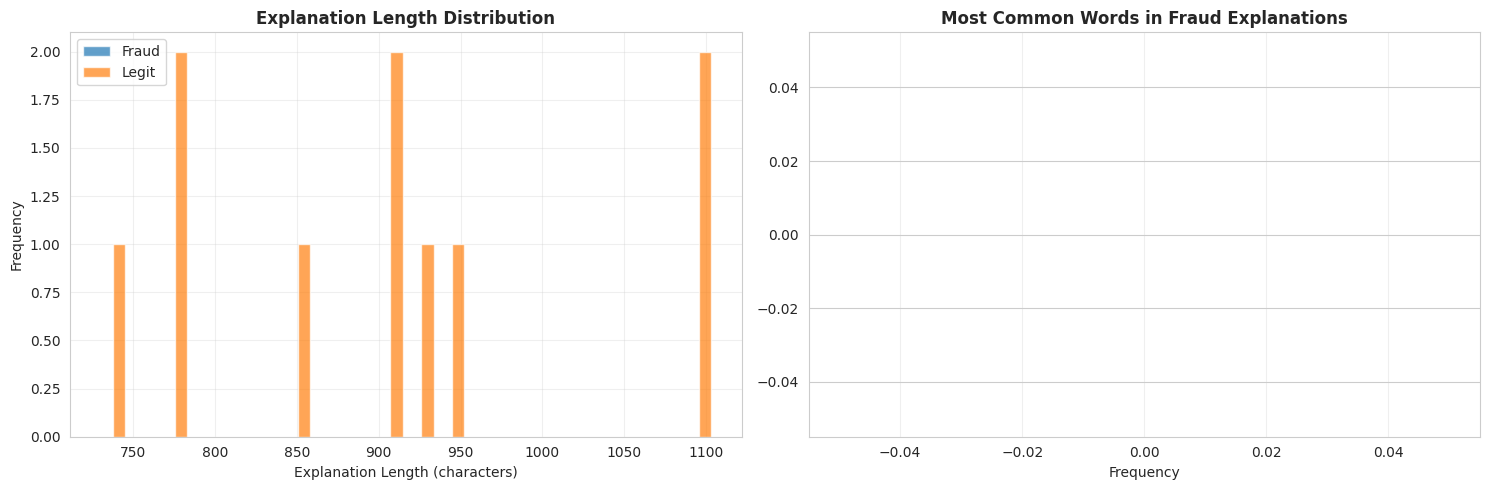


💾 Saved explanations to: /kaggle/working/rag_output/sample_explanations.json


In [36]:
print('='*70)
print('EXPLANATION QUALITY ANALYSIS')
print('='*70)

explanation_stats = {
    'total_explanations': len(explained_df),
    'fraud_explanations': len(explained_df[explained_df['isFraud'] == 1]),
    'legit_explanations': len(explained_df[explained_df['isFraud'] == 0]),
    'avg_explanation_length': explained_df['explanation'].str.len().mean(),
    'min_length': explained_df['explanation'].str.len().min(),
    'max_length': explained_df['explanation'].str.len().max()
}

print(f'\n📊 Explanation Statistics:')
for key, value in explanation_stats.items():
    print(f'   {key}: {value}')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
explained_df['explanation_length'] = explained_df['explanation'].str.len()

fraud_lengths = explained_df[explained_df['isFraud'] == 1]['explanation_length']
legit_lengths = explained_df[explained_df['isFraud'] == 0]['explanation_length']

axes[0].hist([fraud_lengths, legit_lengths], label=['Fraud', 'Legit'], bins=20, alpha=0.7)
axes[0].set_xlabel('Explanation Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Explanation Length Distribution', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

fraud_words = ' '.join(explained_df[explained_df['isFraud'] == 1]['explanation'])
word_freq = pd.Series(fraud_words.split()).value_counts().head(10)

axes[1].barh(word_freq.index, word_freq.values, color='steelblue', alpha=0.8)
axes[1].set_xlabel('Frequency')
axes[1].set_title('Most Common Words in Fraud Explanations', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'explanation_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


print(f'\n💾 Saved explanations to: {explanations_file}')

## Create Interactive Explanation Dashboard

In [37]:
def create_explanation_report(explained_df: pd.DataFrame, output_path: Path):
    """Create an HTML report summarizing explanations."""

    html_template = """
<!DOCTYPE html>
<html>
<head>
    <title>Fraud Detection Explanations</title>
    <style>
        body {{ font-family: Arial, sans-serif; margin: 20px; background-color: #f5f5f5; }}
        .container {{ max-width: 1200px; margin: auto; background: white; padding: 30px; border-radius: 10px; }}
        h1 {{ color: #2c3e50; text-align: center; }}
        .transaction {{ border: 2px solid #ecf0f1; margin: 20px 0; padding: 20px; border-radius: 8px; }}
        .fraud {{ border-color: #e74c3c; background-color: #fadbd8; }}
        .legit {{ border-color: #27ae60; background-color: #d5f4e6; }}
        .header {{ font-size: 18px; font-weight: bold; margin-bottom: 10px; }}
        .details {{ font-size: 14px; color: #555; margin: 5px 0; }}
        .explanation {{ background-color: #f9f9f9; padding: 15px; margin-top: 10px; border-left: 4px solid #3498db; font-style: italic; }}
        .stats {{ background-color: #3498db; color: white; padding: 20px; border-radius: 8px; margin-bottom: 30px; }}
    </style>
</head>
<body>
    <div class="container">
        <h1>🔍 Fraud Detection Explanation Report</h1>

        <div class="stats">
            <h2>Summary Statistics</h2>
            <p><strong>Total Transactions:</strong> {total}</p>
            <p><strong>Fraud Cases:</strong> {fraud_count} ({fraud_pct:.1f}%)</p>
            <p><strong>Legitimate Cases:</strong> {legit_count} ({legit_pct:.1f}%)</p>
        </div>

        <h2>Transaction Explanations</h2>
        {transactions}
    </div>
</body>
</html>
"""

    transactions_html = ""
    for idx, row in explained_df.head(20).iterrows():
        is_fraud = row['isFraud'] == 1
        css_class = 'fraud' if is_fraud else 'legit'
        label = 'FRAUD' if is_fraud else 'LEGITIMATE'

        transaction_html = f"""
        <div class="transaction {css_class}">
            <div class="header">Transaction #{idx} - {label}</div>
            <div class="details"><strong>Type:</strong> {row['type']}</div>
            <div class="details"><strong>Amount:</strong> ${row['amount']:,.2f}</div>
            <div class="details"><strong>Fraud Probability:</strong> {row['fraud_probability']:.1%}</div>
            <div class="explanation">
                <strong>Explanation:</strong><br>
                {row['explanation']}
            </div>
        </div>
        """
        transactions_html += transaction_html

    fraud_count = len(explained_df[explained_df['isFraud'] == 1])
    legit_count = len(explained_df[explained_df['isFraud'] == 0])
    total = len(explained_df)

    html_content = html_template.format(
        total=total,
        fraud_count=fraud_count,
        fraud_pct=fraud_count/total*100 if total else 0,
        legit_count=legit_count,
        legit_pct=legit_count/total*100 if total else 0,
        transactions=transactions_html
    )

    report_file = output_path / 'explanation_report.html'
    with open(report_file, 'w', encoding='utf-8') as f:
        f.write(html_content)

    print(f'✅ Created HTML report: {report_file}')
    return report_file

report_path = create_explanation_report(explained_df, OUTPUT_PATH)
print(f'\n📄 Open the report in your browser: {report_path}')

✅ Created HTML report: /kaggle/working/rag_output/explanation_report.html

📄 Open the report in your browser: /kaggle/working/rag_output/explanation_report.html


## Save Final Results and Metadata

In [38]:
rag_results = {
    'system_info': {
        'vector_database': 'FAISS',
        'embedding_model': 'sentence-transformers/all-MiniLM-L6-v2',
        'total_fraud_cases': int(len(fraud_cases)),
        'llm_enabled': bool(explainer.use_llm),
        'retrieval_enabled': bool(retriever is not None)
    },
    'explanation_stats': {
        key: (
            float(value) if isinstance(value, (np.floating, float))
            else int(value) if isinstance(value, (np.integer, int))
            else value
        )
        for key, value in explanation_stats.items()
    },
    'output_files': {
        'fraud_cases_db': str(cases_file),
        'vector_db': str(VECTOR_DB_PATH / 'fraud_cases_faiss'),
        'explanations': str(explanations_file),
        'batch_results': str(explained_file),
        'html_report': str(report_path)
    },
    'sample_explanations': [
        {
            **item,
            'fraud_probability': float(item['fraud_probability'])
        }
        for item in explanations[:5]
    ]
}

def _json_serializer(obj):
    if isinstance(obj, (np.integer,)):
        return int(obj)
    if isinstance(obj, (np.floating,)):
        return float(obj)
    if isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    if isinstance(obj, (pd.Series, pd.Index)):
        return obj.tolist()
    if isinstance(obj, Path):
        return str(obj)
    raise TypeError(f'Object of type {type(obj)} is not JSON serializable')

results_file = OUTPUT_PATH / 'rag_llm_results.json'
with open(results_file, 'w', encoding='utf-8') as f:
    json.dump(rag_results, f, indent=2, default=_json_serializer)

print(f'\n💾 Saved RAG results to: {results_file}')


💾 Saved RAG results to: /kaggle/working/rag_output/rag_llm_results.json


## Final Summary

In [39]:
print('='*70)
print('🎉 RAG + LLM INTEGRATION COMPLETE (KAGGLE EDITION)')
print('='*70)

retrieval_status = 'Active' if retriever else 'Not available'
llm_status = 'Active' if explainer.use_llm else 'Template-based'

print(f'\n📊 System Components:')
print(f'   ✅ Vector Database: {len(fraud_cases)} fraud cases indexed')
print(f'   ✅ Embedding Model: sentence-transformers/all-MiniLM-L6-v2')
print(f'   ✅ Retrieval System: {retrieval_status}')
print(f'   ✅ LLM Integration: {llm_status}')

print(f'\n📁 Generated Outputs:')
print(f'   ✅ Fraud case database: {cases_file}')
print(f'   ✅ Vector database: {VECTOR_DB_PATH}')
print(f'   ✅ Sample explanations: {explanations_file}')
print(f'   ✅ Batch results: {explained_file}')
print(f'   ✅ HTML report: {report_path}')
print(f'   ✅ Results summary: {results_file}')

print(f'\n📝 Key Features:')
print(f'   • Case-based reasoning with vector similarity search')
print(f'   • Natural language explanations for fraud predictions')
print(f'   • Multi-modal feature integration (graph + sequence + transaction)')
print(f'   • Scalable RAG architecture for production deployment')

if RUNNING_ON_KAGGLE:
    print(f'\n💾 Kaggle Tips:')
    print(f'   - Outputs persist in /kaggle/working; download before the session ends')
    print(f'   - Re-run the installation cell after restarting the kernel')
    print(f'   - Local LLM defaults to 4-bit loading for GPU efficiency')

print('\n' + '='*70)
print('✅ NOTEBOOK 06 (KAGGLE) COMPLETE - EXPLAINABLE AI READY!')
print('='*70)

🎉 RAG + LLM INTEGRATION COMPLETE (KAGGLE EDITION)

📊 System Components:
   ✅ Vector Database: 173 fraud cases indexed
   ✅ Embedding Model: sentence-transformers/all-MiniLM-L6-v2
   ✅ Retrieval System: Active
   ✅ LLM Integration: Active

📁 Generated Outputs:
   ✅ Fraud case database: /kaggle/working/rag_output/fraud_cases_database.json
   ✅ Vector database: /kaggle/working/vector_db
   ✅ Sample explanations: /kaggle/working/rag_output/sample_explanations.json
   ✅ Batch results: /kaggle/working/rag_output/transactions_with_explanations.csv
   ✅ HTML report: /kaggle/working/rag_output/explanation_report.html
   ✅ Results summary: /kaggle/working/rag_output/rag_llm_results.json

📝 Key Features:
   • Case-based reasoning with vector similarity search
   • Natural language explanations for fraud predictions
   • Multi-modal feature integration (graph + sequence + transaction)
   • Scalable RAG architecture for production deployment

💾 Kaggle Tips:
   - Outputs persist in /kaggle/working; 